In [1]:
import gym
from gym import wrappers
from gym.spaces.utils import flatdim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import io
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

In [2]:
def play_video(ep_number: int):
    video = io.open(f"./gym-results/rl-video-episode-{ep_number}.mp4", 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

100%|██████████| 50000/50000 [00:12<00:00, 3974.13it/s]


Text(0.5, 1.0, 'Episode lengths over 26 episodes')

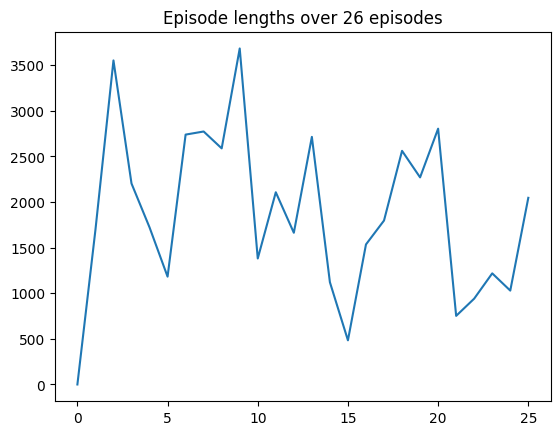

In [6]:
env = gym.make("Acrobot-v1")
env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
env.reset(seed=42)

num_steps = 50000
random_lengths = [0]
random_rewards = [0]
ep_len = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info, _ = env.step(action)
   random_rewards.append(reward)

   if done:
      random_lengths.append(ep_len)
      observation = env.reset()
      ep_len = 0
   
   ep_len += 1
env.close()

plt.plot(random_lengths)
plt.title(f"Episode lengths over {len(random_lengths)} episodes")

100%|██████████| 50000/50000 [00:14<00:00, 3510.83it/s]


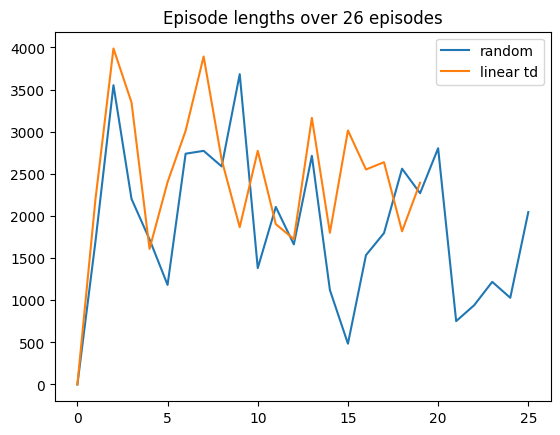

In [22]:
# Simple Linear Function grad-Q learning
env = gym.make("Acrobot-v1")
env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
obs = env.reset(seed=42)

num_steps = 50000
lr = 1e-4
epsilon = 0.01
gamma = 0.99
weights = np.zeros((flatdim(env.action_space), flatdim(env.observation_space)))

def policy(action_vals, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()    
    return np.random.choice(np.where(action_vals == action_vals.max())[0])


td_lengths = [0]
td_rewards = [0]
ep_len = 0
for _ in trange(num_steps):
    action_vals = np.matmul(weights, obs)
    action = policy(action_vals, epsilon)
    next_obs, reward, done, info, _ = env.step(action)
    td_rewards.append(reward)

    bellman_error = (reward + np.max(gamma * np.matmul(weights, next_obs))) - action_vals[action]
    grad = obs
    weights[action, :] += lr * bellman_error * grad

    if done:
        td_lengths.append(ep_len)
        next_obs = env.reset()
        ep_len = 0

    ep_len += 1
    obs = next_obs
env.close()

plt.plot(random_lengths, label='random')
plt.plot(td_lengths, label='linear td')
plt.title(f"Episode lengths over {len(random_lengths)} episodes")
plt.legend()

In [23]:
play_video(27)